In [263]:
# import dependencies

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
import warnings

In [264]:
# grab our data from the raw github page
url = 'https://raw.githubusercontent.com/owid/co2-data/master/owid-co2-data.csv'
df = pd.read_csv(url)

# This is going to be our complete database. Offers a lot more data along with potential for using Machine Learning
df.to_csv('CO2_emissions.csv',index=False)
print(len(df))
df.head()

25989


,iso_code,country,year,co2,co2_per_capita,trade_co2,cement_co2,cement_co2_per_capita,coal_co2,coal_co2_per_capita,...,ghg_excluding_lucf_per_capita,methane,methane_per_capita,nitrous_oxide,nitrous_oxide_per_capita,population,gdp,primary_energy_consumption,energy_per_capita,energy_per_gdp
0,AFG,Afghanistan,1949,0.015,0.002,NaN,NaN,NaN,0.015,0.002,...,NaN,NaN,NaN,NaN,NaN,7624058.0,NaN,NaN,NaN,NaN
1,AFG,Afghanistan,1950,0.084,0.011,NaN,NaN,NaN,0.021,0.003,...,NaN,NaN,NaN,NaN,NaN,7752117.0,9.421400e+09,NaN,NaN,NaN
2,AFG,Afghanistan,1951,0.092,0.012,NaN,NaN,NaN,0.026,0.003,...,NaN,NaN,NaN,NaN,NaN,7840151.0,9.692280e+09,NaN,NaN,NaN
3,AFG,Afghanistan,1952,0.092,0.012,NaN,NaN,NaN,0.032,0.004,...,NaN,NaN,NaN,NaN,NaN,7935996.0,1.001733e+10,NaN,NaN,NaN
4,AFG,Afghanistan,1953,0.106,0.013,NaN,NaN,NaN,0.038,0.005,...,NaN,NaN,NaN,NaN,NaN,8039684.0,1.063052e+10,NaN,NaN,NaN


In [265]:
# We have some useless data in this dataframe (iso_codes like 'International Transport', 'North America (excl. USA)', etc.)
# These are being dropped since they are legitimately useless. We will also drop the 'OWID_WRL' iso_code which is the CO2
# emissions for the globe since it's not necessary for our analysis.

df = df[df['iso_code'].notna()]
df = df[df['iso_code'] != 'OWID_WRL']

# To get an idea for which countries we should forecast, lets sort the countries in descending order with highest emission
# totals for the year 2020 since it's the most recent

df[df['year']==2020].sort_values(['co2'], ascending=False)[:10]

,iso_code,country,year,co2,co2_per_capita,trade_co2,cement_co2,cement_co2_per_capita,coal_co2,coal_co2_per_capita,...,ghg_excluding_lucf_per_capita,methane,methane_per_capita,nitrous_oxide,nitrous_oxide_per_capita,population,gdp,primary_energy_consumption,energy_per_capita,energy_per_gdp
4723,CHN,China,2020,10667.887,7.412,NaN,858.233,0.596,7421.101,5.156,...,NaN,NaN,NaN,NaN,NaN,1.439324e+09,NaN,40404.443,28071.824,NaN
24661,USA,United States,2020,4712.771,14.238,NaN,40.795,0.123,888.649,2.685,...,NaN,NaN,NaN,NaN,NaN,3.310026e+08,NaN,24387.388,73677.319,NaN
11277,IND,India,2020,2441.792,1.769,NaN,122.908,0.089,1587.552,1.150,...,NaN,NaN,NaN,NaN,NaN,1.380004e+09,NaN,8884.380,6437.936,NaN
19597,RUS,Russia,2020,1577.136,10.807,NaN,20.306,0.139,356.946,2.446,...,NaN,NaN,NaN,NaN,NaN,1.459345e+08,NaN,7865.165,53895.194,NaN
12336,JPN,Japan,2020,1030.775,8.150,NaN,25.376,0.201,402.979,3.186,...,NaN,NaN,NaN,NaN,NaN,1.264765e+08,NaN,4730.588,37402.909,NaN
11595,IRN,Iran,2020,745.035,8.870,NaN,23.877,0.284,5.114,0.061,...,NaN,NaN,NaN,NaN,NaN,8.399295e+07,NaN,3341.689,39785.350,NaN
9619,DEU,Germany,2020,644.310,7.690,NaN,13.287,0.159,199.077,2.376,...,NaN,NaN,NaN,NaN,NaN,8.378394e+07,NaN,3364.175,40152.984,NaN
20269,SAU,Saudi Arabia,2020,625.508,17.967,NaN,25.593,0.735,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,3.481387e+07,NaN,2933.478,84261.772,NaN
21590,KOR,South Korea,2020,597.605,11.656,NaN,22.871,0.446,282.883,5.518,...,NaN,NaN,NaN,NaN,NaN,5.126918e+07,NaN,3274.316,63865.188,NaN
11409,IDN,Indonesia,2020,589.500,2.155,NaN,33.804,0.124,300.518,1.099,...,NaN,NaN,NaN,NaN,NaN,2.735236e+08,NaN,2120.519,7752.600,NaN


In [3]:
# Select the data for the USA, grab the year and CO2, set index to the year(type=int64), drop the name on the axis
df = df[df['iso_code']=='USA']
df = pd.DataFrame(df[['year','co2']]).dropna()
df = df.set_index(['year'])
df = df.rename_axis(None, axis=1)

In [4]:
# Select the last 100 years of data (training the model on more than that is unecessary)
df = df[len(df)-100:]
df.head()

,co2
year,
1921,1423.669
1922,1435.758
1923,1896.736
1924,1698.320
1925,1758.098


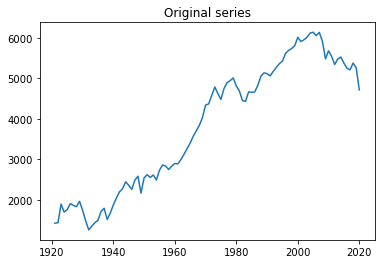

In [5]:
# Original Series
plt.plot(df)
plt.title('Original series');

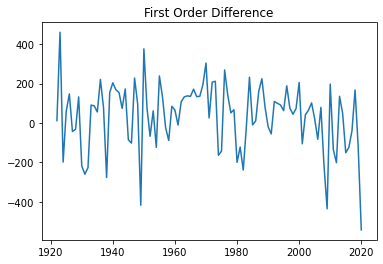

In [11]:
# First order difference
plt.plot(df.diff().dropna())
plt.title('First Order Difference');

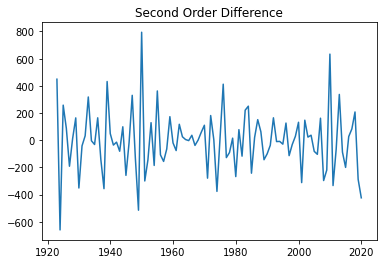

In [12]:
# Second order difference
plt.plot(df.diff().diff().dropna())
plt.title('Second Order Difference');

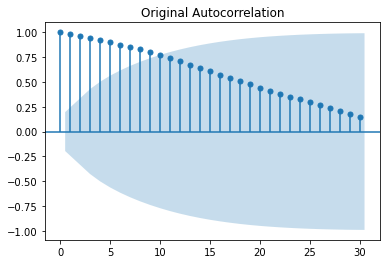

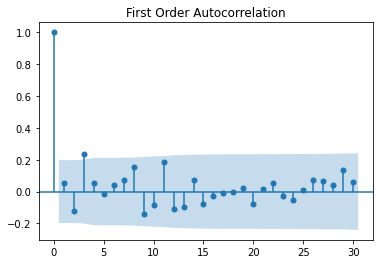

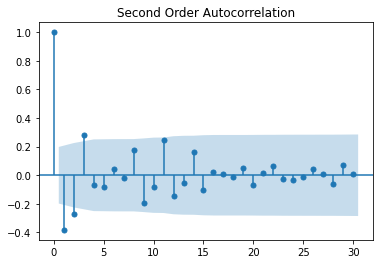

In [13]:
plot_acf(df,lags=30,title='Original Autocorrelation');
plot_acf(df.diff().dropna(),lags=30,title='First Order Autocorrelation');
plot_acf(df.diff().diff().dropna(),lags=30,title='Second Order Autocorrelation');

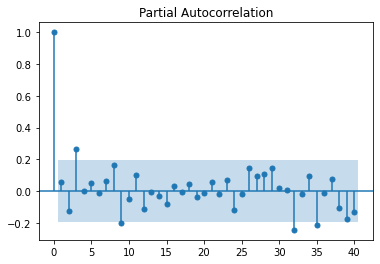

In [98]:
# Used to find q (in this case we will use 1)
plot_pacf(df.diff().dropna(),lags=40);

In [17]:
## This is to gauge what value we should think about using for d in ARIMA(p,d,q) (in this case it is 1)

# first order differencing
result = adfuller(df.dropna())
print('p-value: ', result[1])

# second order differencing
result = adfuller(df.diff().dropna())
print('p-value: ', result[1])

 # third order differencing
result = adfuller(df.diff().diff().dropna())
print('p-value: ', result[1])

p-value:  0.605668474063761
p-value:  0.0019058799049643592
p-value:  1.318959371705595e-08


<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

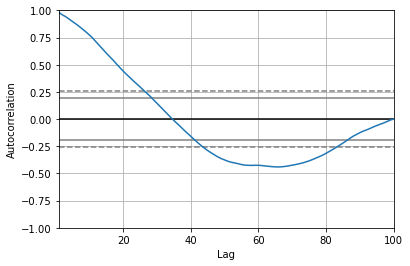

In [18]:
# This is to help us identify the value for p in our model
# Look at the number of lags for the autocorrelation to fall inside our boundary (in this case ~25)
autocorrelation_plot(df)

In [19]:
model = ARIMA(df, order=(25,1,1))
model_fit = model.fit()

print(model_fit.summary())

C:\Users\nodna\anaconda3\envs\mlenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\nodna\anaconda3\envs\mlenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\nodna\anaconda3\envs\mlenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                               SARIMAX Results                                
Dep. Variable:                    co2   No. Observations:                  100
Model:                ARIMA(25, 1, 1)   Log Likelihood                -636.552
Date:                Mon, 09 May 2022   AIC                           1327.103
Time:                        12:23:45   BIC                           1397.172
Sample:                             0   HQIC                          1355.453
                                - 100                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3641      1.456     -0.250      0.803      -3.218       2.490
ar.L2         -0.0488      0.213     -0.230      0.818      -0.465       0.368
ar.L3          0.2521      0.237      1.063      0.2

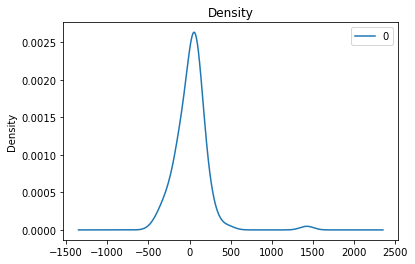

In [20]:
residuals = pd.DataFrame(model_fit.resid)
residuals.plot(kind='kde', title='Density')
plt.show()

In [21]:
# show the distribution of our residuals
print(residuals.describe()[0])

count     100.000000
mean       22.941583
std       207.335389
min      -425.006802
25%       -92.441467
50%        34.884178
75%        96.943485
max      1423.669000
Name: 0, dtype: float64


In [8]:
# our CO2 emissions
X=df.values

# selecting a testing size (70% train, 30% test)
size = int(len(X)*.7)

# slices our original data into train,test sets
train, test = X[0:size], X[size:len(X)]

# stores our past values, initialized to hold the training set
history = [x for x in train]

# list to hold our model's predictions
predictions = list()

# iterate through our test data
for t in range(len(test)):
    
    warnings.filterwarnings("ignore")
    
    # Fit the model to our initialzied data (training set) using (p,d,q) from the analysis above
    model = ARIMA(history, order=(25,1,1))
    
    # Fit the model
    model_fit = model.fit()
    
    # predict the next value based on the fitted model.
    output = model_fit.forecast()
    yhat = output[0]
    
    # add the prediction to our list of predictions
    predictions.append(yhat)
    
    
    obs = test[t]
    history.append(obs)
    
    #print('predicted = %f, expected = %f' %(yhat,obs))

rmse = np.sqrt(mean_squared_error(test, predictions))

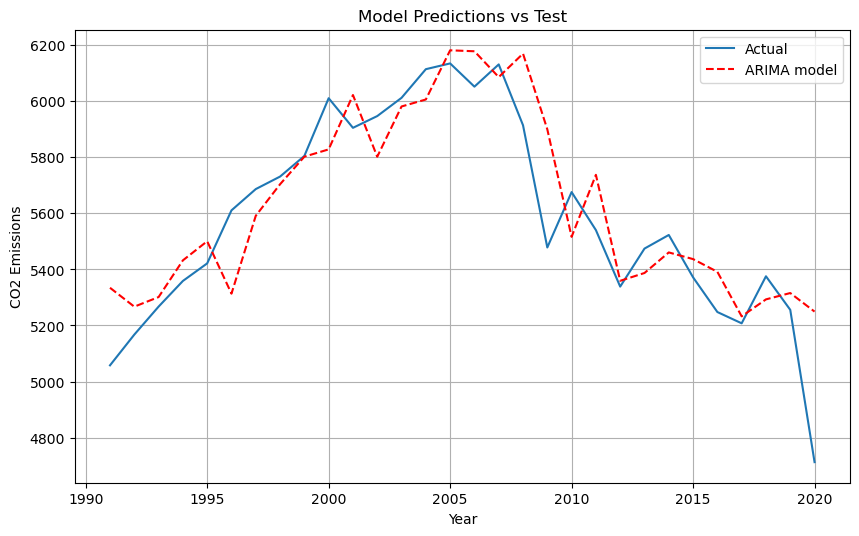

RMSE: 177.090


In [9]:
x = df.index[-len(test):].values
plt.figure(figsize=(10,6),dpi=100)
plt.plot(x, test, label='Actual')
plt.plot(x,predictions, color='r', linestyle='--',label='ARIMA model')
plt.title('Model Predictions vs Test')
plt.xlabel('Year')
plt.ylabel('CO2 Emissions')
plt.legend()
plt.grid()
plt.show()
print("RMSE: %.3f" % rmse)

In [10]:
history = df.values
predictions = list()
forecast = 20

for t in range(forecast):
    warnings.filterwarnings("ignore")
    model = ARIMA(history, order=(25,1,1))
    model_fit = model.fit()
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    history = np.append(history,yhat)
    

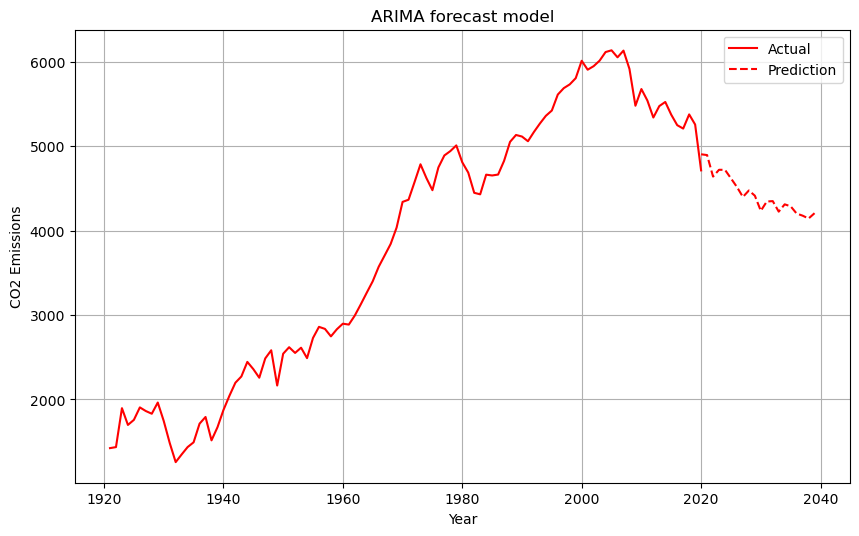

In [11]:
x =  list(range(df.index[-1],df.index[-1]+forecast))
plt.figure(figsize=(10,6),dpi=100)
plt.plot(df.index[:],history[:-forecast], color='red',label='Actual')
plt.plot(x,predictions,color='red', linestyle='--',label='Prediction')
plt.title('ARIMA forecast model')
plt.xlabel('Year')
plt.ylabel('CO2 Emissions')
plt.legend()
plt.grid()
plt.show()

In [49]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# our CO2 emissions
X=df.values

# selecting a testing size (70% train, 30% test)
size = int(len(X)*.7)

# slices our original data into train,test sets
train, test = X[0:size], X[size:len(X)]

# stores our past values, initialized to hold the training set
history = [x for x in train]

# list to hold our model's predictions
predictions = list()

# iterate through our test data
for t in range(len(test)):
    
    warnings.filterwarnings("ignore")
    
    # Fit the model to our initialzied data (training set) using (p,d,q) from the analysis above
    model = SARIMAX(history, order=(20,1,1), seasonal_order=(0,1,0,12))
    
    # Fit the model
    model_fit = model.fit()
    
    # predict the next value based on the fitted model.
    output = model_fit.forecast()
    yhat = output[0]
    
    # add the prediction to our list of predictions
    predictions.append(yhat)
    
    
    obs = test[t]
    history.append(obs)
    
    #print('predicted = %f, expected = %f' %(yhat,obs))

rmse = np.sqrt(mean_squared_error(test, predictions))

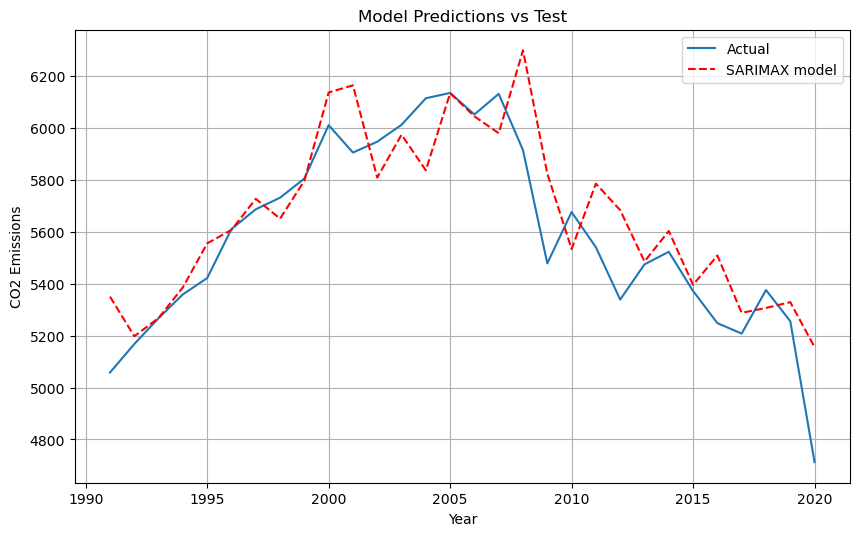

RMSE: 188.894


In [50]:
x = df.index[-len(test):].values
plt.figure(figsize=(10,6),dpi=100)
plt.plot(x, test, label='Actual')
plt.plot(x,predictions, color='r', linestyle='--',label='SARIMAX model')
plt.title('Model Predictions vs Test')
plt.xlabel('Year')
plt.ylabel('CO2 Emissions')
plt.legend()
plt.grid()
plt.show()
print("RMSE: %.3f" % rmse)

In [51]:
residuals = pd.DataFrame(model_fit.resid)
residuals.describe()[0]

count      99.000000
mean        2.327353
std       244.407808
min      -597.539299
25%      -139.431406
50%       -15.814969
75%       119.530776
max      1423.669000
Name: 0, dtype: float64

In [60]:
history = df.values
predictions = list()
forecast = 30

for t in range(forecast):
    warnings.filterwarnings("ignore")
    model = SARIMAX(history, order=(20,1,1), seasonal_order=(0,1,0,10))
    model_fit = model.fit()
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    history = np.append(history,yhat)

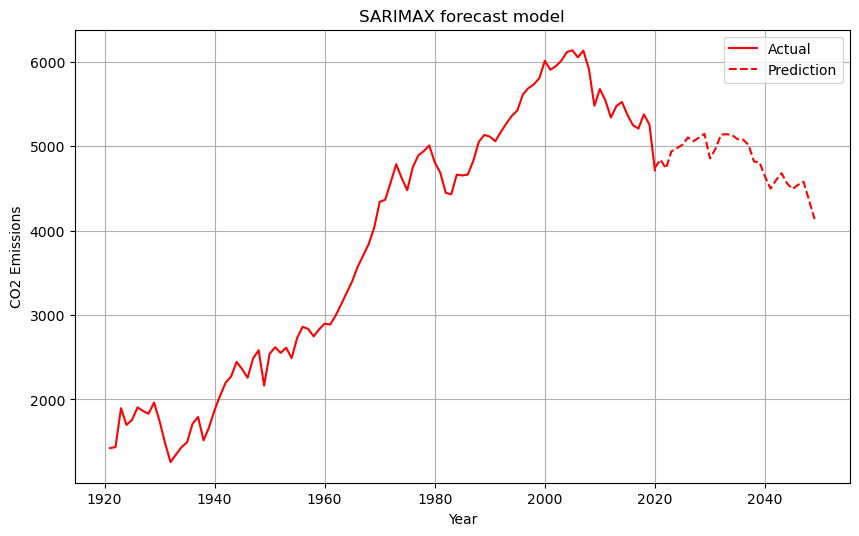

In [61]:
x =  list(range(df.index[-1],df.index[-1]+forecast))
plt.figure(figsize=(10,6),dpi=100)
plt.plot(df.index[:],history[:-forecast], color='red',label='Actual')
plt.plot(x,predictions,color='red', linestyle='--',label='Prediction')
plt.title('SARIMAX forecast model')
plt.xlabel('Year')
plt.ylabel('CO2 Emissions')
plt.legend()
plt.grid()
plt.show()